In [1]:
%cd ..

/Users/pedrobedmar/GoogleDrive/MASTER_BIG_DATA/tfm/code


In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from etl.esios.provider import ESIOSDataProvider
from etl.generic_provider import GenericDataProvider
import lab.functions as func

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

SEED=0
np.random.seed(SEED)

In [14]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [15]:
esios_provider = ESIOSDataProvider()
esios_tickers = esios_provider.get_tickers()
print(esios_tickers)

investingdotcom_tickers = ["DAILY_TTF_PRICE", "MONTHLY_TTF_PRICE"]
investingdotcom_provider = GenericDataProvider("datalake/clean/investingdotcom/", want_metadata=False, tickers=investingdotcom_tickers)
print(investingdotcom_tickers)

marketwatch_tickers = ["DAILY_COAL_PRICE"]
marketwatch_provider = GenericDataProvider("datalake/clean/marketwatch/", want_metadata=False, tickers=marketwatch_tickers)
print(marketwatch_tickers)

icap_tickers = ["CO2_EUA_PRICE"]
icap_provider = GenericDataProvider("datalake/clean/ICAP/", want_metadata=False, tickers=icap_tickers)
print(icap_tickers)

['DEMANDA_REAL', 'GENERACIÓN_MEDIDA_TOTAL', 'GENERACIÓN_MEDIDA_EÓLICA', 'GENERACIÓN_MEDIDA_HIDRÁULICA', 'GENERACIÓN_MEDIDA_NUCLEAR', 'GENERACIÓN_MEDIDA_SOLAR', 'GENERACIÓN_MEDIDA_CICLO_COMBINADO', 'GENERACIÓN_MEDIDA_CARBÓN', 'PRECIO_MERCADO_SPOT_DIARIO']
['DAILY_TTF_PRICE', 'MONTHLY_TTF_PRICE']
['DAILY_COAL_PRICE']
['CO2_EUA_PRICE']


In [16]:
forecasting_horizon = 30

nb_windows = 15
step_size = 13

lags = [1, 2, 6, 7, 13, 14, 28, 30, 31]
date_features = ["day", "day_of_week", "week_of_year", "month"]

regressor_list = [KNeighborsRegressor(), RandomForestRegressor(random_state=SEED, n_jobs=-1),
                      GradientBoostingRegressor(random_state=SEED)]
regressor_str_list = ["KNeighborsRegressor", "RandomForestRegressor", "GradientBoostingRegressor"]
save_path="lab/models_skforecast/daily/"

In [17]:
def load_and_preprocess_daily_data(start_index, end_index, date_features):
    index_type = "DatetimeIndex"
    esios_spot = esios_provider.get_series("PRECIO_MERCADO_SPOT_DIARIO", freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="mean")
    esios_df = esios_provider.get_all_series(freq="H", index_type=index_type, start_index=start_index, end_index=end_index, resample_by="D", group_mode="sum")
    ttf_df = investingdotcom_provider.get_series(investingdotcom_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    coal_df = marketwatch_provider.get_series(marketwatch_tickers[0], freq="D", index_type=index_type, start_index=start_index, end_index=end_index)
    co2_df = icap_provider.get_series(icap_tickers[0], index_type=index_type, freq="D", start_index=start_index, end_index=end_index)

    X = esios_df.drop(['PRECIO_MERCADO_SPOT_DIARIO', 'GENERACIÓN_MEDIDA_TOTAL'], axis=1)
    X = pd.concat([X, ttf_df, coal_df, co2_df], axis=1)
    lags = []

    df_date_features = func.add_date_features(esios_spot, X, lags, 1, date_features)

    data_train = df_date_features.iloc[:-forecasting_horizon, :].copy()
    data_test = df_date_features.iloc[-forecasting_horizon:, :].copy()

    initial_window_length = len(data_train) - step_size*(nb_windows-1)

    return data_train, data_test, initial_window_length

## Prepandemic

In [18]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2018-04-01", end_index="2020-03-31", date_features=date_features)
print(initial_window_length)

519


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


In [19]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

,PRECIO_MERCADO_SPOT_DIARIO,DEMANDA_REAL,GENERACIÓN_MEDIDA_EÓLICA,GENERACIÓN_MEDIDA_HIDRÁULICA,GENERACIÓN_MEDIDA_NUCLEAR,GENERACIÓN_MEDIDA_SOLAR,GENERACIÓN_MEDIDA_CICLO_COMBINADO,GENERACIÓN_MEDIDA_CARBÓN,DAILY_TTF_PRICE,DAILY_COAL_PRICE,CO2_EUA_PRICE,month,day,day_of_week,week_of_year
2020-03-02,22.116667,703973.333333,344986.664,89386.512,144234.457,32939.227,19469.209,13894.736,8.885,46.85,23.48,3,2,0,10
2020-03-03,26.340417,730263.333333,342082.909,90830.215,170343.958,27187.793,24167.666,14092.045,9.170,47.00,23.34,3,3,1,10
2020-03-04,32.506250,719498.000000,292459.736,99971.009,170680.973,36770.572,45335.333,13147.764,8.910,47.10,23.79,3,4,2,10
2020-03-05,24.895000,716626.666667,352499.718,89245.038,170756.974,31718.580,22769.281,15426.494,8.850,47.60,23.77,3,5,3,10
2020-03-06,21.736250,720205.333333,349272.148,97852.001,170803.983,49487.414,20980.222,14842.077,8.645,47.10,23.39,3,6,4,10
2020-03-07,27.832083,646300.000000,202412.243,99961.860,170822.611,55085.400,35630.322,14424.830,8.645,47.10,23.39,3,7,5,10
2020-03-08,26.640000,598223.500000,173986.138,95940.167,170807.682,57446.736,32511.091,10866.952,8.645,47.10,23.39,3,8,6,10
2020-03-09,32.638750,702592.166667,226192.639,116473.212,170733.720,57904.978,41882.431,29082.646,8.625,46.45,23.25,3,9,0,11
2020-03-10,34.915417,706978.166667,146021.433,127798.266,170639.345,62009.576,49543.674,24113.155,8.995,46.40,24.06,3,10,1,11
2020-03-11,38.689167,708394.833333,71424.457,132848.239,170534.460,56506.684,78416.803,23333.332,9.370,46.45,23.89,3,11,2,11


In [10]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,modelling_time
2,GradientBoostingRegressor,1.394157,4.802096,110.117901
1,RandomForestRegressor,1.578725,5.445467,99.214774
0,KNeighborsRegressor,1.964546,6.758963,156.200170


In [11]:
save_name="daily_pre.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [8]:
save_name="daily_pre.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

### Final model

MASE: 1.0435015266801535


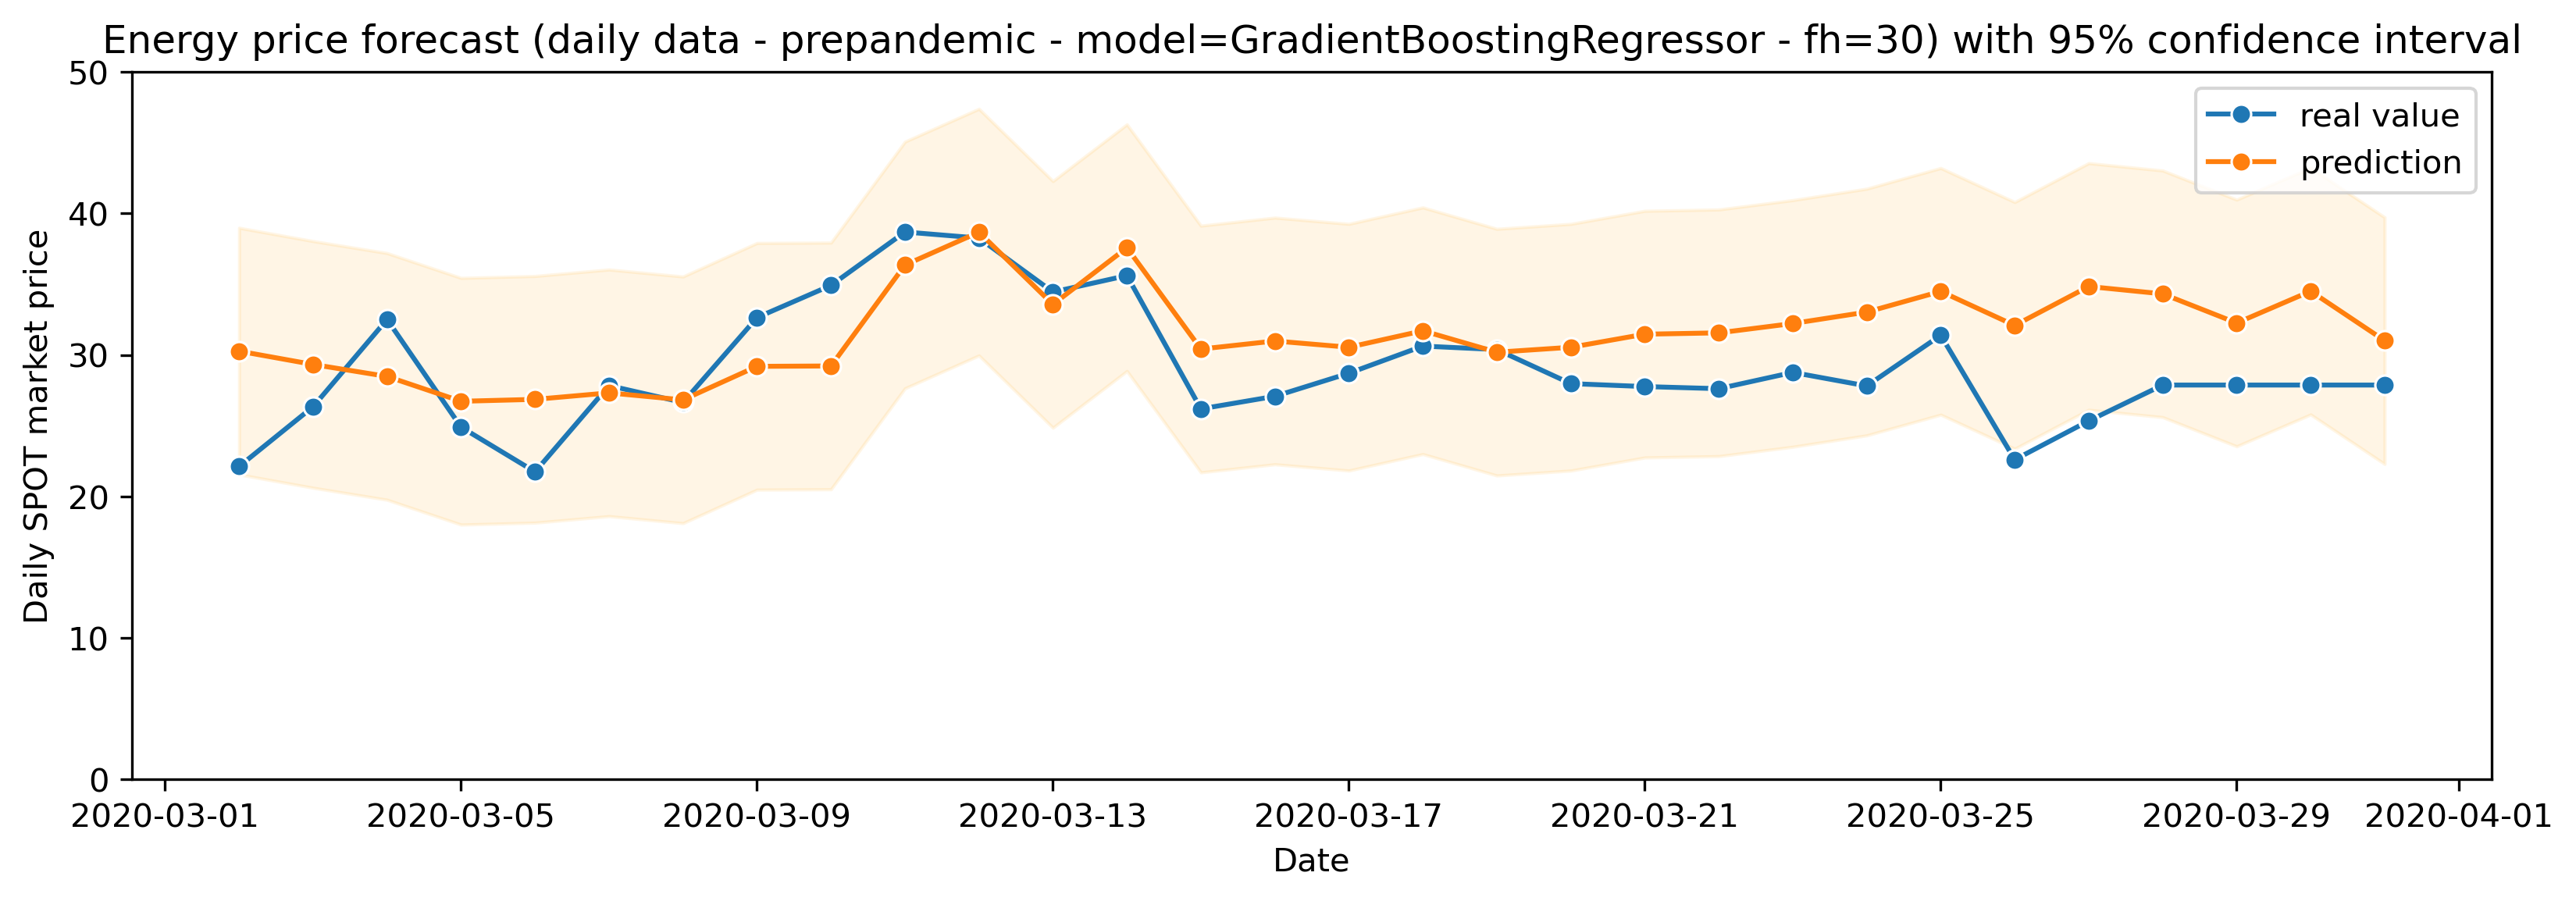

In [9]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
plot_lim = [0,50]
plot_title = f"Energy price forecast (daily data - prepandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval"

func.final_model_skforecast(data_train, data_test, best_model, best_model_string, lags, date_features, forecasting_horizon, cv_results_df_summary, plot_lim, plot_title)

## Postpandemic

In [10]:
data_train, data_test, initial_window_length = load_and_preprocess_daily_data(start_index="2021-04-01", end_index="2023-03-31", date_features=date_features)
print(initial_window_length)

518


weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


Model: KNeighborsRegressor
MASEs: [1.2378693013472355, 1.4775021934732822, 1.6702057615461168, 1.752988397977579, 1.910247403226136, 2.030911339168693, 2.1034159854083523, 2.301351988353412, 2.018557498365131, 2.928243924009878, 4.571978969028293, 3.3996515043447286, 2.3553179568166036, 2.333406270471978, 2.9177795951100554]
MAEs: [19.16725277777778, 22.543755555555553, 25.32620277777778, 27.13265, 30.469236111111105, 32.854416666666665, 34.555955555555556, 37.84575833333333, 33.23061666666667, 48.449520833333324, 76.08400694444444, 56.7622138888889, 40.19276527777778, 40.147436111111105, 50.722199999999994]
Modelling time: 140.16247415542603

Model: RandomForestRegressor
MASEs: [1.1514676167537843, 1.7488014407579429, 2.576363408775968, 2.1726148209350393, 2.1947809345227616, 2.5262498333413226, 1.4551287357769656, 1.3625911701962148, 2.0925328207245344, 2.8955384719383463, 2.9178813264214396, 2.597625234907179, 1.201552715858569, 1.5345422428415003, 0.6109504139621942]
MAEs: [17.8294

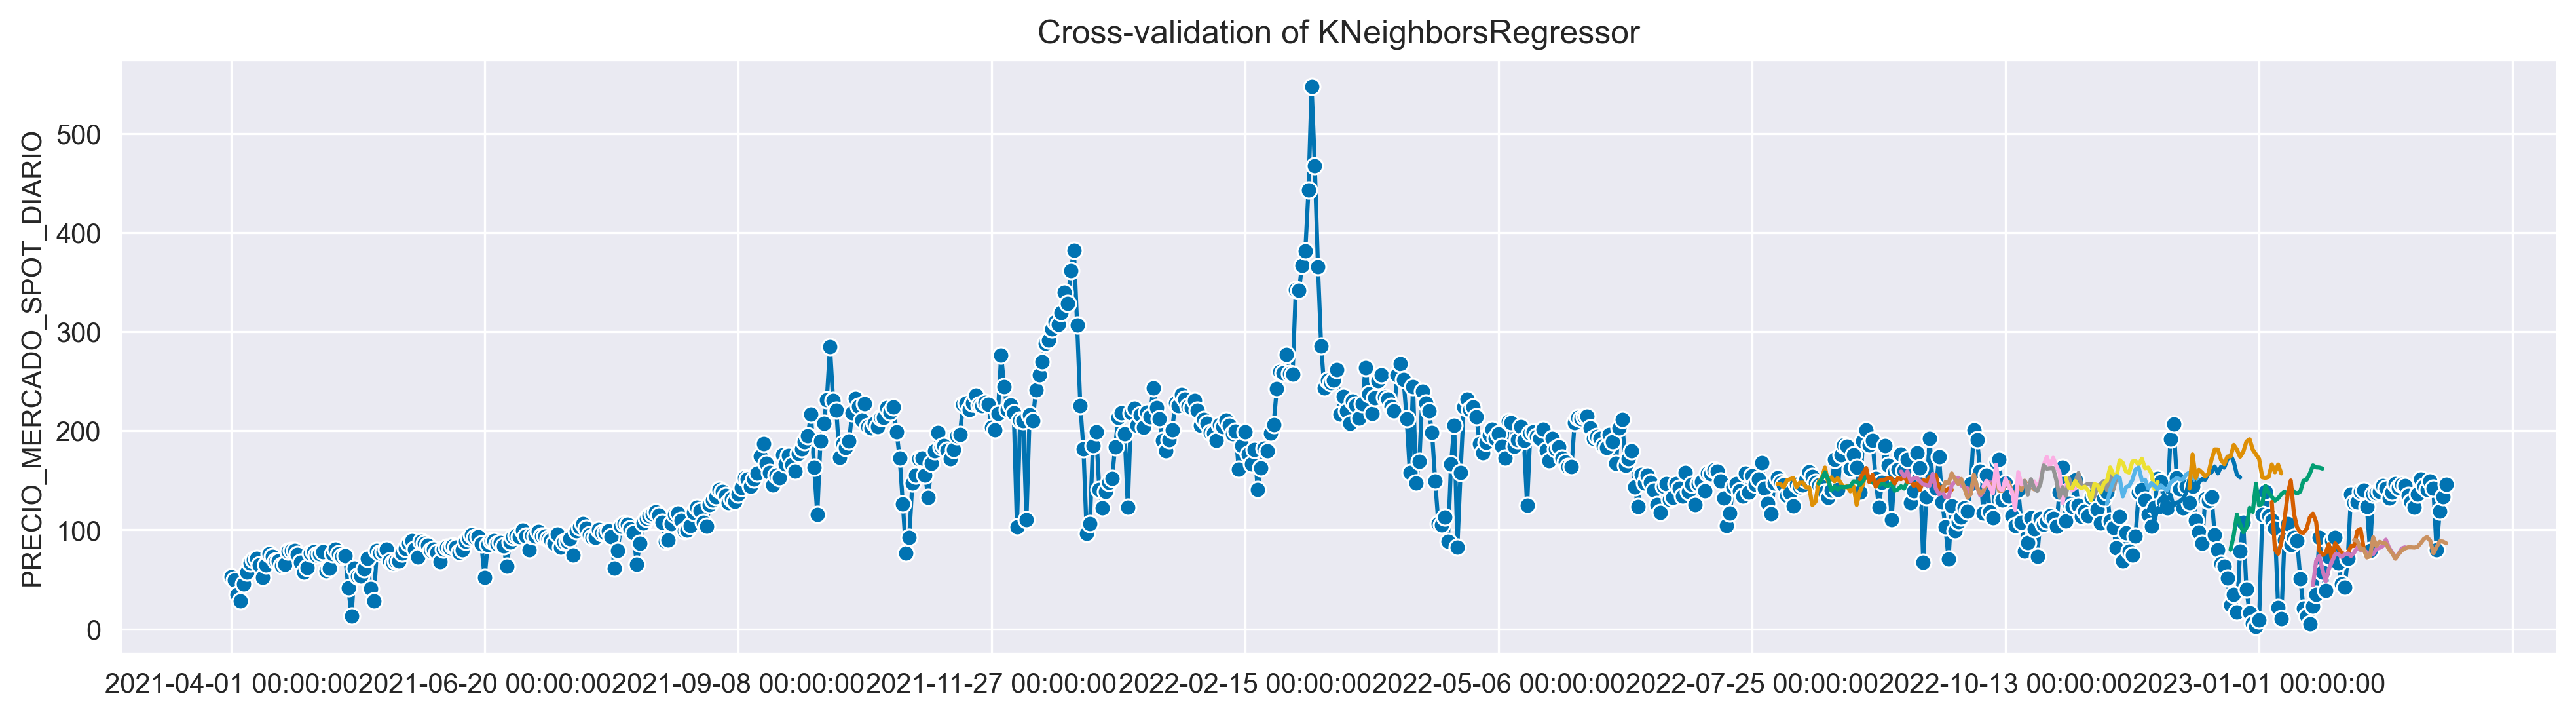

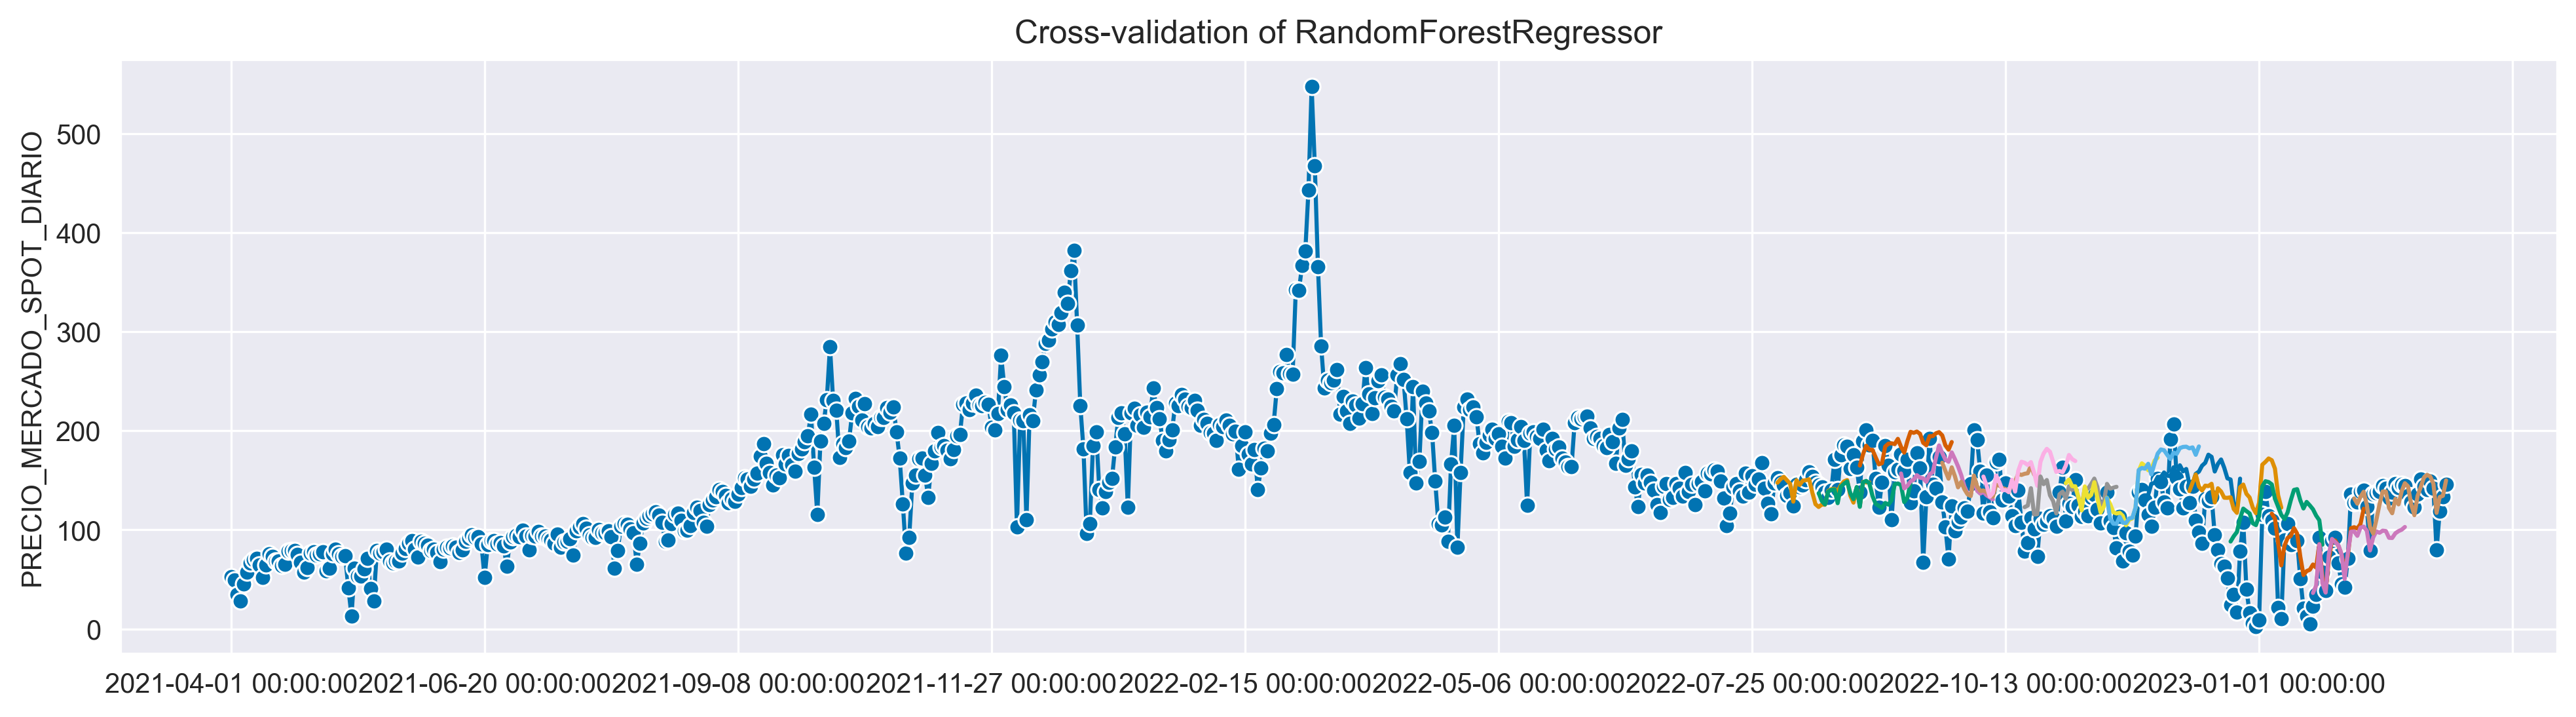

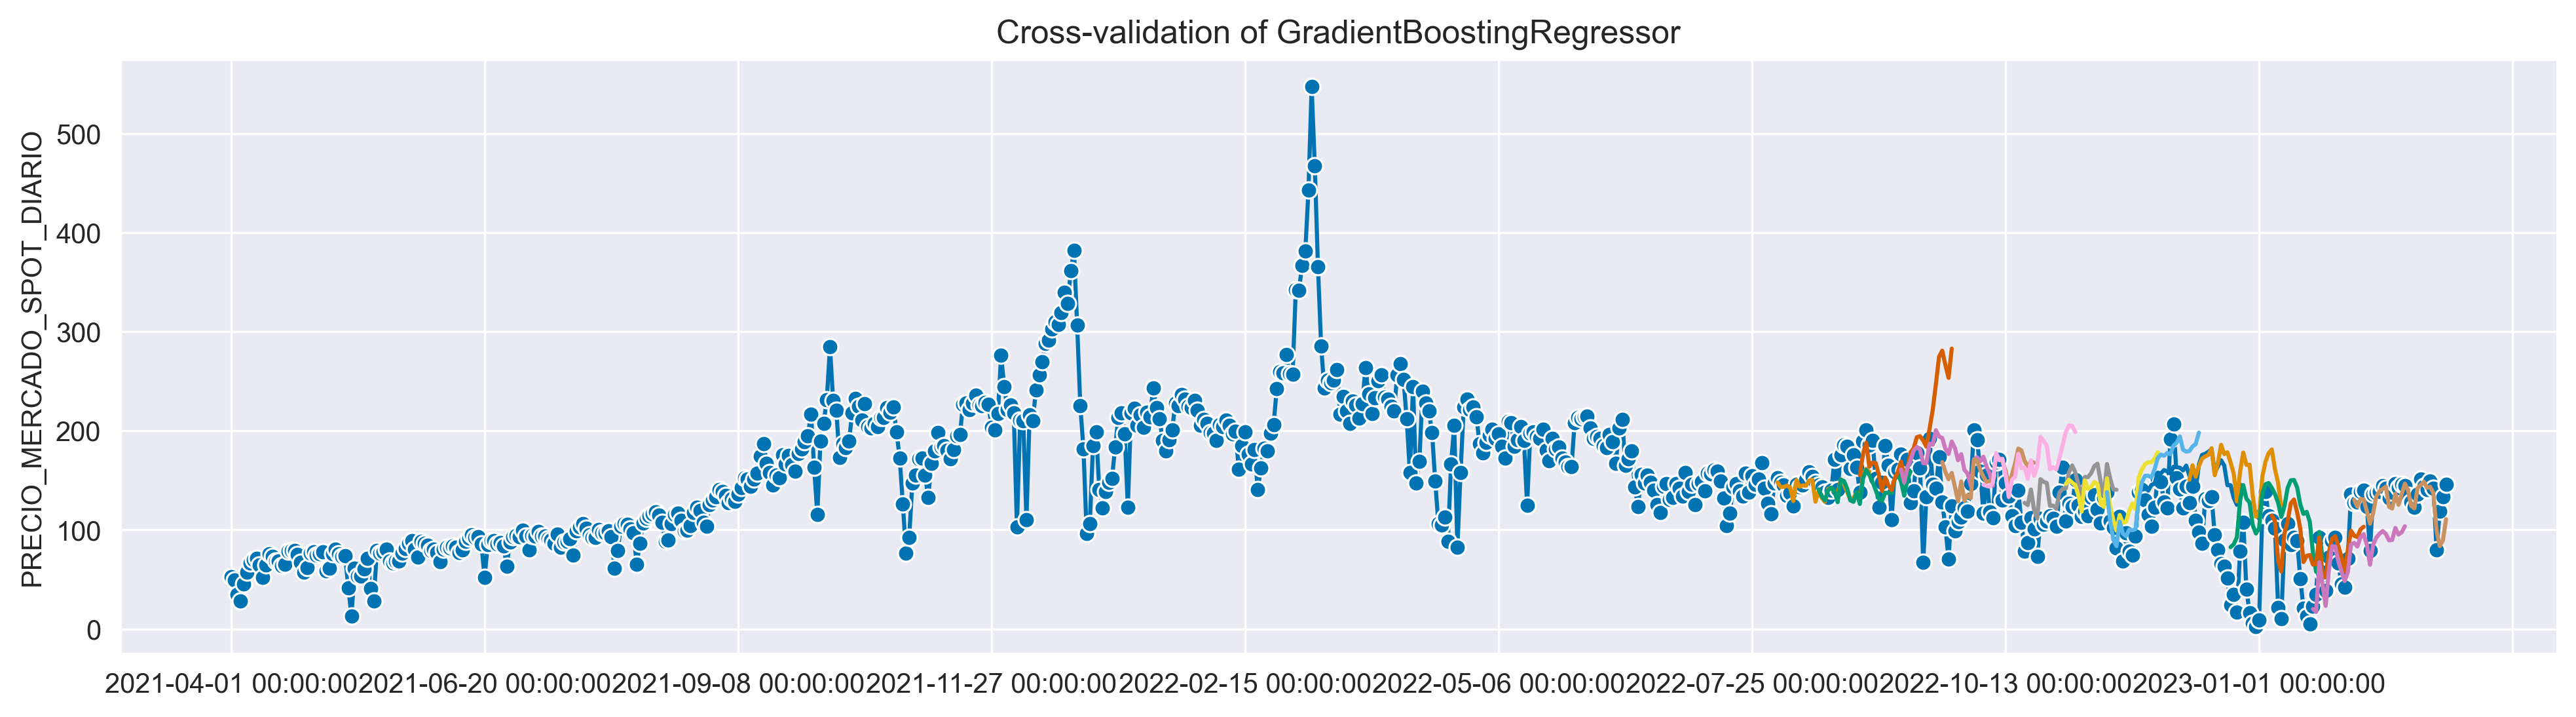

In [15]:
cv_results_df_summary = func.crossval_model_skforecast(data_train, regressor_list, regressor_str_list, initial_window_length, nb_windows, step_size, lags, date_features, forecasting_horizon)

In [16]:
cv_results_df_summary = cv_results_df_summary.sort_values("mean_mase")
cv_results_df_summary

,model,mean_mase,mean_mae,modelling_time
1,RandomForestRegressor,1.935908,31.413906,104.510004
2,GradientBoostingRegressor,2.153450,34.953035,67.304649
0,KNeighborsRegressor,2.333962,38.365599,140.162474


In [17]:
save_name="daily_post.pkl"
os.makedirs(save_path, exist_ok=True)
cv_results_df_summary.to_pickle(save_path + save_name)

In [11]:
save_name="daily_post.pkl"
cv_results_df_summary = pd.read_pickle(save_path+save_name)

### Final model

MASE: 1.5848425881201196


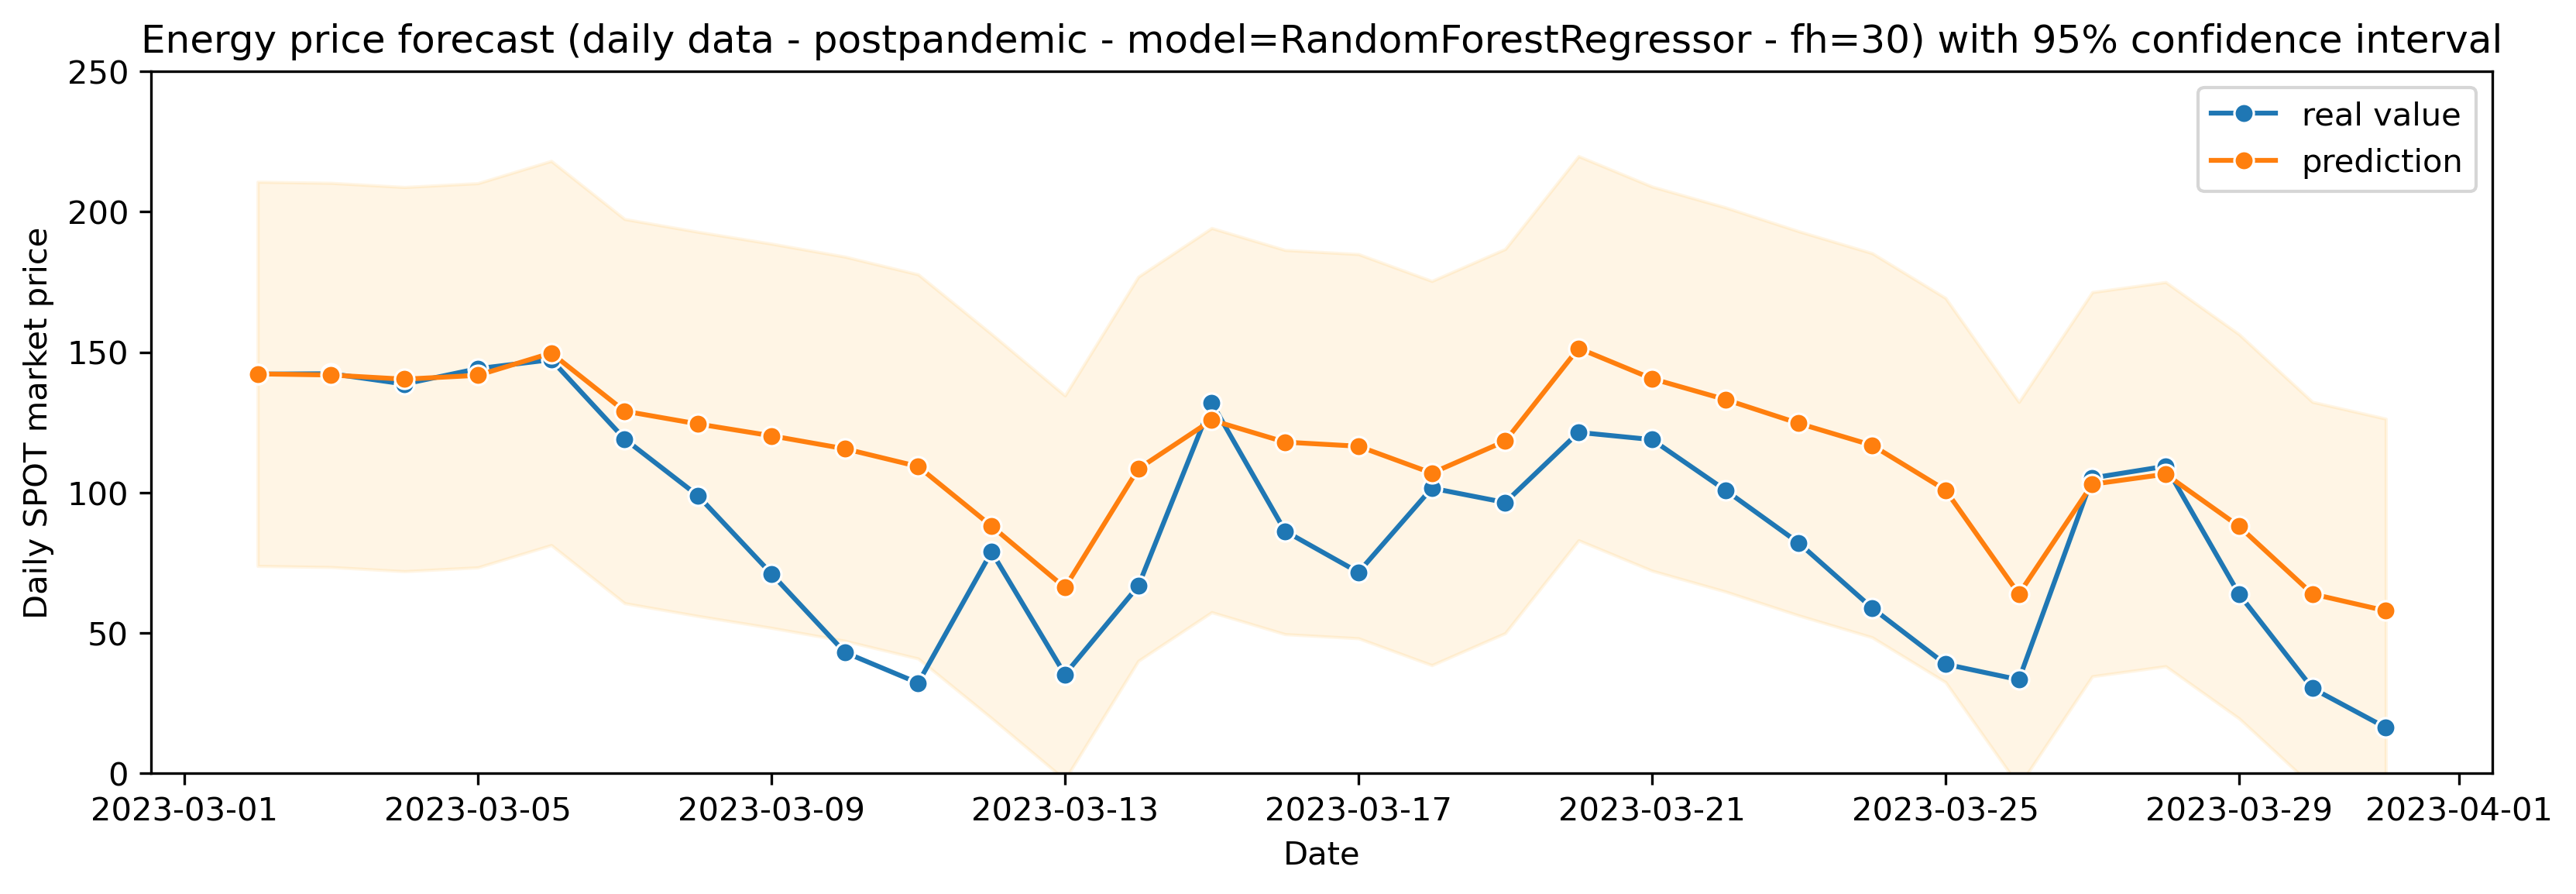

In [12]:
best_model_string = cv_results_df_summary.iloc[0, 0]
best_model = regressor_list[regressor_str_list.index(best_model_string)]
plot_lim = [0,250]
plot_title = f"Energy price forecast (daily data - postpandemic - model={best_model_string} - fh={forecasting_horizon}) with 95% confidence interval"

func.final_model_skforecast(data_train, data_test, best_model, best_model_string, lags, date_features, forecasting_horizon, cv_results_df_summary, plot_lim, plot_title)